In [2]:
# Imports & Setup
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

import matplotlib.pyplot as plt
import cv2


In [3]:
# Device & Paths
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMAGE_DIR = Path("../data/images")


In [4]:
# Load Data (ONLY for selection)
fusion_df = pd.read_csv("../data/raw/train.csv")
fusion_df["id"] = fusion_df["id"].astype(int)

# Keep only rows with downloaded images
image_ids = sorted([
    int(float(p.stem)) for p in IMAGE_DIR.glob("*.png")
])

fusion_df = (
    fusion_df[fusion_df["id"].isin(image_ids)]
    .drop_duplicates(subset="id")
    .reset_index(drop=True)
)

fusion_df.shape


(5980, 21)

In [5]:
# Select Cheap vs Expensive Samples
cheap_samples = fusion_df.nsmallest(3, "price")
expensive_samples = fusion_df.nlargest(3, "price")

cheap_samples[["id", "price"]], expensive_samples[["id", "price"]]


(              id  price
 5920  3028200080  81000
 3883  3883800011  82000
 107   1322049150  85000,
               id    price
 3844  1924059029  4668000
 5961  9362000040  3400000
 1975  9808100150  3345000)

In [6]:
# Image Preprocessing (Same as Training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [7]:
# Load Pretrained ResNet18
model = models.resnet18(
    weights=models.ResNet18_Weights.IMAGENET1K_V1
)
model.fc = nn.Identity()
model.to(device)
model.eval()

for p in model.parameters():
    p.requires_grad = False


In [8]:
# Grad-CAM Implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor):
        output = self.model(input_tensor)
        output.mean().backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam.squeeze().cpu().numpy()


In [9]:
# Helper: Load Image by Property ID
def load_image(property_id):
    path_1 = IMAGE_DIR / f"{property_id}.png"
    path_2 = IMAGE_DIR / f"{property_id}.0.png"

    img_path = path_1 if path_1.exists() else path_2
    img = Image.open(img_path).convert("RGB")
    return img, img_path


In [10]:
# Visualization Function
def show_gradcam(property_id, price, title):
    img, img_path = load_image(property_id)

    input_tensor = transform(img).unsqueeze(0).to(device)
    input_tensor.requires_grad = True

    cam = gradcam.generate(input_tensor)

    # Resize CAM to image size
    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(
        np.uint8(255 * cam), cv2.COLORMAP_JET
    )
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    img_np = np.array(img.resize((224, 224)))
    overlay = 0.6 * img_np + 0.4 * heatmap
    overlay = overlay.astype(np.uint8)

    plt.figure(figsize=(4, 4))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"{title}\n₹{price:,}")
    plt.show()


In [11]:
# Initialize Grad-CAM
gradcam = GradCAM(
    model=model,
    target_layer=model.layer4
)


/Users/rahulchauhan/Desktop/Satellite-Imagery-Based-Property-Valuation/venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


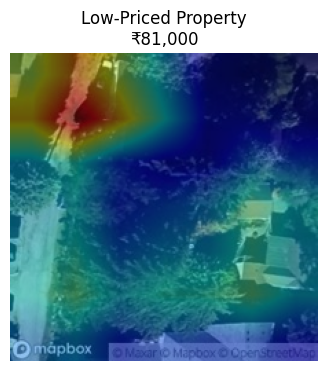

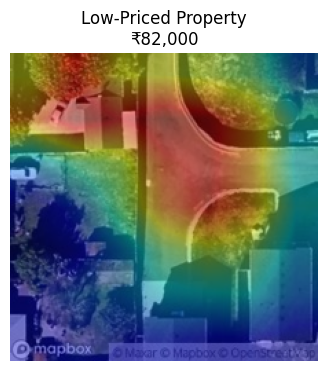

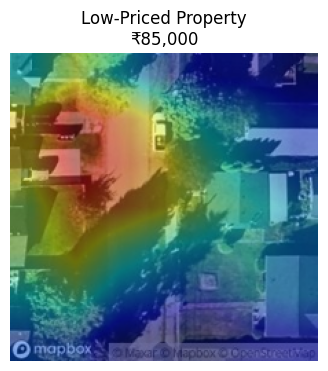

In [12]:
# Visualize CHEAP Properties
for _, row in cheap_samples.iterrows():
    show_gradcam(
        property_id=row["id"],
        price=row["price"],
        title="Low-Priced Property"
    )


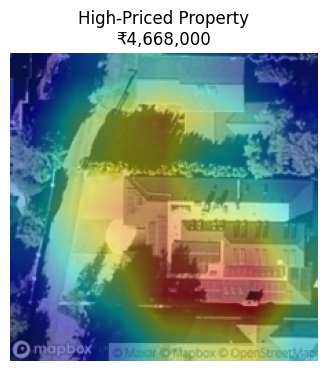

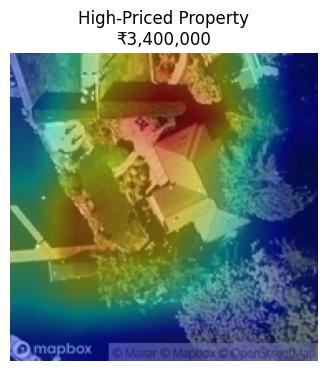

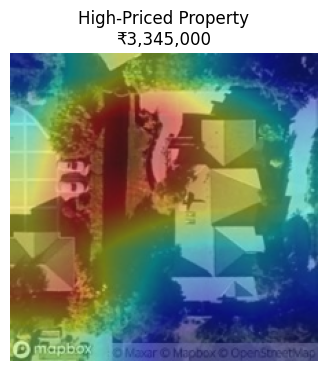

In [13]:
# Visualize EXPENSIVE Properties
for _, row in expensive_samples.iterrows():
    show_gradcam(
        property_id=row["id"],
        price=row["price"],
        title="High-Priced Property"
    )
